In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm

import utils

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'data/raw/06-19/'
bids = np.load(DATA_DIR + 'bid-record.npy')
asks = np.load(DATA_DIR + 'ask-record.npy')
times = np.array(list(map(np.datetime64, map(datetime.fromtimestamp, np.load(DATA_DIR + 'time-record.npy')))))
print(bids.shape)

(40000, 64, 2)


In [3]:
def construct_df(agg_sz=1, roll_mean_window_size=20):
    """agg_sz is in USD
    roll_mean_window_size is integer size for window"""

    agg_bid_vol = utils.get_aggregate_volume(bids, is_bid=True, agg_sz=agg_sz)
    agg_ask_vol = utils.get_aggregate_volume(asks, is_bid=False, agg_sz=agg_sz)
    agg_oir = (agg_bid_vol - agg_ask_vol) / (agg_bid_vol + agg_ask_vol)

    df = pd.DataFrame(data={'bid': bids[:, -1, 0],
                            'ask': asks[:, 0, 0],
                            'bid-volume': agg_bid_vol,
                            'ask-volume': agg_ask_vol,
                            'mid': (bids[:, -1, 0] + asks[:, 0, 0]) / 2,
                            'oir': agg_oir,
                            'time': times})

    df['dmid'] = df['mid'] - df['mid'].shift(1)
    df['oi'] = utils.get_oi(df)

    df['roll-mid'] = df['mid'].rolling(roll_mean_window_size).mean()
    
    return df

def gen_graphs(df):
    plt.figure(figsize=(30,20))

    height = 4

    plt.subplot(height, 2, 1)
    plt.plot(df['dmid'][0:1000]), plt.title('dmid')
    plt.subplot(height, 2, 2)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['dmid'].autocorr(lag=lag) for lag in lags]), plt.title('dmid-autocorr')

    plt.subplot(height, 2, 3)
    plt.plot(df['oir'][0:1000]), plt.title('oir')
    plt.subplot(height, 2, 4)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].autocorr(lag=lag) for lag in lags]), plt.title('oir-autocorr')

    plt.subplot(height, 2, 5)
    plt.plot(df['oi'][0:300]), plt.title('oi')
    plt.subplot(height, 2, 6)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].autocorr(lag=lag) for lag in lags]), plt.title('oi-autocorr')

    plt.subplot(height, 2, 7)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('oi-dmid-corr')
    plt.subplot(height, 2, 8)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('voi-dmid-corr')

CPU times: user 105 ms, sys: 43.8 ms, total: 148 ms
Wall time: 147 ms


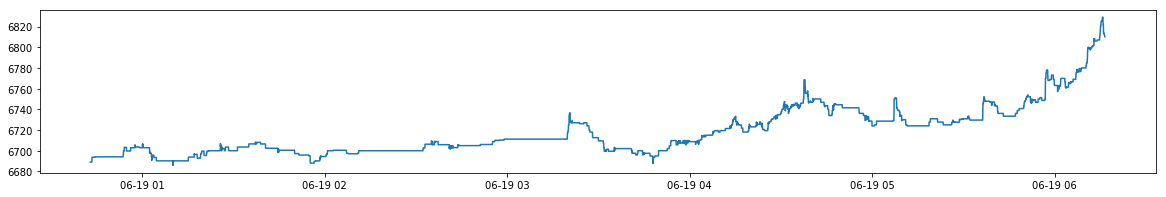

In [5]:
%%time
# construct_df(1, 20).to_pickle('data/dfs/06-19.pkl')
plt.figure(figsize=(20,3))
plt.plot_date(times, construct_df(agg_sz=1, roll_mean_window_size=20)['mid'], fmt='-')

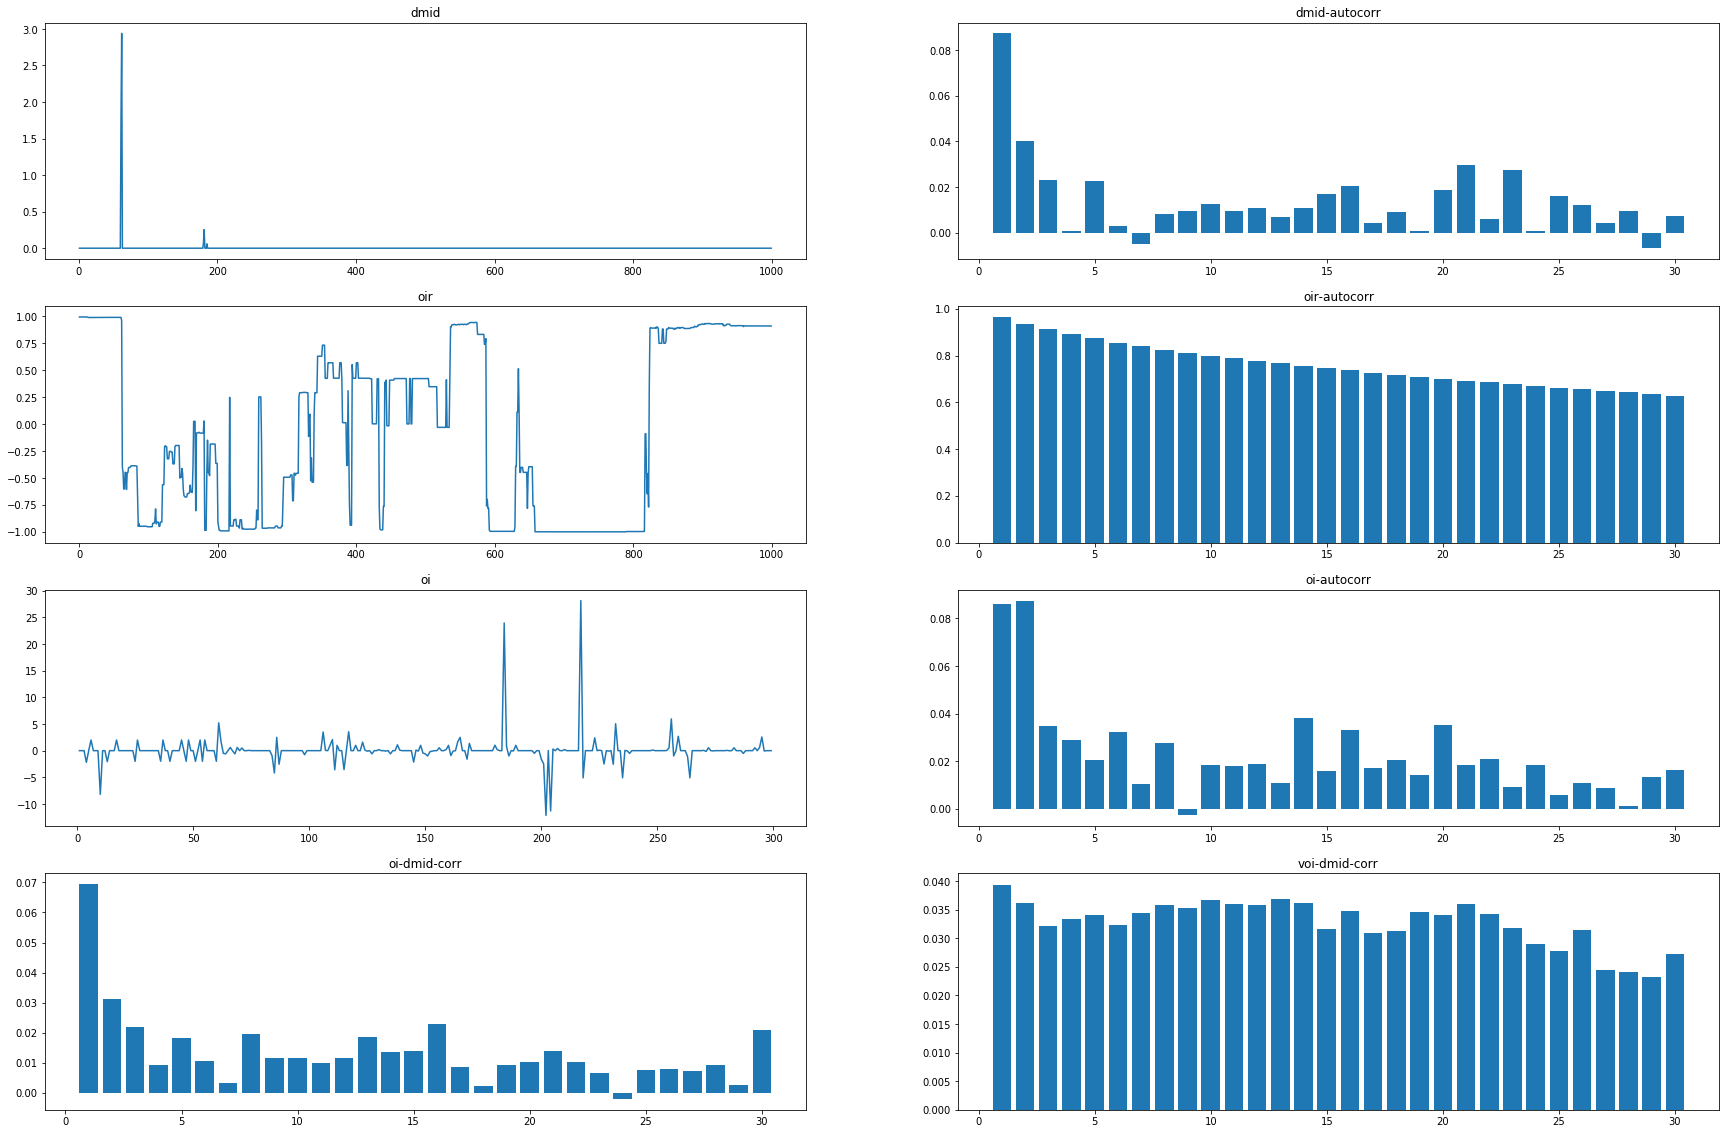

In [6]:
gen_graphs(construct_df(agg_sz=1, roll_mean_window_size=20))

In [51]:
def fit(agg_sz=1, roll_mean_window_size=20, oi_features=5, df = None):
    """oi_features: how many timesteps back do we use OI"""

    if df is None:
        df = construct_df(agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    y = df['roll-mid'].shift(-roll_mean_window_size) - df['mid']
    y = y.round(decimals=8) # make things close to zero (floating point error) actually zero

    X = np.zeros((df.shape[0], oi_features))
    for i in range(oi_features):
        X[:, i] = df['oi'].shift(i).values

    model = sm.OLS(y, sm.add_constant(X), missing = 'drop')
    results = model.fit()
    return results

fit().rsquared_adj

0.02340378423941325

In [48]:
%%time
rsquared_adj = []
best_rsquared_adj = 0.0
for agg_sz in [0.5, 1, 2, 3, 4, 5]:
    for roll_mean_window_size in [10, 20, 30]:
        for oi_features in [3, 4, 5, 6, 7, 8, 9, 10]:
            model = fit(agg_sz=agg_sz,
                        roll_mean_window_size=roll_mean_window_size,
                        oi_features=oi_features)
            rsquared_adj.append((model.rsquared_adj, agg_sz, roll_mean_window_size, oi_features))
            if model.rsquared_adj > best_rsquared_adj:
                best_rsquared_adj = model.rsquared_adj
                print(model.rsquared_adj, agg_sz, roll_mean_window_size, oi_features)

0.016520062161428872 0.5 10 3
0.01811692673316334 0.5 10 4
0.019612178046071405 0.5 10 5
0.02080364841698401 0.5 10 6
0.021720913126389796 0.5 10 7
0.022687125555301835 0.5 10 8
0.023514093459719554 0.5 10 9
0.024287159713646256 0.5 10 10
0.025167372728417514 0.5 20 7
0.026787543927410895 0.5 20 8
0.028227408372490603 0.5 20 9
0.029600236052996443 0.5 20 10
0.03071528235948351 0.5 30 9
0.03238488061542777 0.5 30 10
0.032878118170888815 1 30 10
CPU times: user 13.7 s, sys: 6.29 s, total: 20 s
Wall time: 19.8 s


In [49]:
rsquared_adj.sort()
for row in rsquared_adj[:-10:-1]:
    print(row)

(0.032878118170888815, 1, 30, 10)
(0.03238488061542777, 0.5, 30, 10)
(0.03141176558311598, 1, 30, 9)
(0.03071528235948351, 0.5, 30, 9)
(0.03023379078346511, 1, 20, 10)
(0.02996954148205644, 1, 30, 8)
(0.029600236052996443, 0.5, 20, 10)
(0.029408872796135133, 5, 30, 10)
(0.02901457361663029, 1, 20, 9)


Sharpe Ratio: 0.011754685462041444


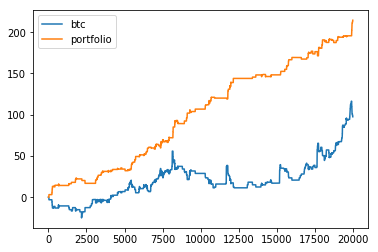

In [111]:
def predict(model, df, oi_features):
    X = np.zeros((df.shape[0], oi_features))
    for i in range(oi_features):
        X[:, i] = df['oi'].shift(i).values
    return model.predict(sm.add_constant(X))

def backtest(agg_sz=1,
             roll_mean_window_size=20,
             oi_features=5,
             train_frac=0.5,
             trade_thresh=0.2,
             taker_fee=3e-3):
    """
    train_frac: What percentage of the data (taken as prefix) should be used for train.
                The remainder is used for test.
    trade_thresh: What our linear model needs to produce in order for us to update our position. positive.
    taker_fee: percentage, default is given in https://docs.gdax.com/#trading-fees
    """

    df = construct_df(agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    train_sz = round(df.shape[0] * train_frac)    
    train_df = df[0:train_sz]
    test_df = df[train_sz:]
    
    model = fit(agg_sz=agg_sz,
                roll_mean_window_size=roll_mean_window_size,
                oi_features=oi_features,
                df=df)
    
    preds = pd.Series(predict(model, test_df, oi_features))
    
    buy_times = preds > trade_thresh
    sell_times = preds < trade_thresh
    sell_times *= 1 - buy_times # due to NaNs, we want to enforce that we never have both a buy and sell
    
    portfolio = buy_times - sell_times
    portfolio[portfolio == 0] = np.nan
    portfolio = portfolio.ffill()
    portfolio *= portfolio < 0
    portfolio = portfolio.shift(1) # we execute trades in the future
    
    returns = pd.Series(test_df['dmid'].values)
    
    portfolio_returns = portfolio * returns
    
    #TODO: Add taker_fees
    
    return returns, portfolio_returns

def get_sharpe_ratio(returns, portfolio_returns):
    sr = (portfolio_returns - returns).mean() / (portfolio_returns - returns).std()
    return sr

r, pr = backtest(agg_sz=1,
                 roll_mean_window_size=30,
                 oi_features=10,
                 trade_thresh=0.05)
print("Sharpe Ratio:", get_sharpe_ratio(r, pr))
plt.plot(r.cumsum(), label='btc')
plt.plot(pr.cumsum(), label='portfolio')
plt.legend()